In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
demographics=[
'wealth_index',
'population_density',
]
day=list(range(8,20))
night=list(range(8))+list(range(20,24))
city_name='Jakarta'
freq='W'

In [4]:
print('Import')
start = timer()
trips = pd.read_csv(os.path.join(path_to_data,source,'processed',country,'OD_'+city_name+'.csv'))
admin = gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
print("Done in", round(timer()-start), "sec")  

Import
Done in 58 sec


In [6]:
admin.head()

,ADM4_EN,ADM4_PCODE,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,a_km2,median_age,wealth_index,total_population,geometry
0,1 Ilir,ID1671060006,Ilir Timur II,ID1671060,Kota Palembang,ID1671,Sumatera Selatan,ID16,2.086247,26.0,0.589971,5792.0,"POLYGON ((104.82248 -2.98102, 104.82165 -2.985..."
1,1 Ulu,ID1671020008,Seberang Ulu I,ID1671020,Kota Palembang,ID1671,Sumatera Selatan,ID16,0.209298,25.0,0.606387,12058.0,"POLYGON ((104.75516 -3.01316, 104.75480 -3.013..."
2,10 Ilir,ID1671062001,Ilir Timur III,ID1671062,Kota Palembang,ID1671,Sumatera Selatan,ID16,0.156444,NaN,NaN,NaN,"POLYGON ((104.77081 -2.98185, 104.77082 -2.981..."
3,11 Ilir,ID1671062002,Ilir Timur III,ID1671062,Kota Palembang,ID1671,Sumatera Selatan,ID16,0.077040,NaN,NaN,NaN,"POLYGON ((104.77081 -2.98185, 104.77070 -2.981..."
4,11 Ulu,ID1671030014,Seberang Ulu II,ID1671030,Kota Palembang,ID1671,Sumatera Selatan,ID16,0.227913,24.0,0.529232,7543.0,"POLYGON ((104.77317 -2.99340, 104.77316 -2.993..."


In [23]:
trips = pd.read_csv(os.path.join(path_to_data,source,'processed',country,'OD_'+city_name+'.csv'))
trips.date_origin=pd.to_datetime(trips.date_origin)

In [203]:
volumes=trips.groupby(
[pd.Grouper(key='date_origin', freq=freq),admin_id+'_origin']
)['trip'].sum().rename('volume').reset_index().rename(columns={admin_id+'_origin':admin_id,'date_origin':'date'})

outflows=trips[trips[admin_id+'_origin']!=trips[admin_id+'_destination']].groupby(
[pd.Grouper(key='date_origin', freq=freq),admin_id+'_origin']
)['trip'].sum().rename('outflow').reset_index().rename(columns={admin_id+'_origin':admin_id,'date_origin':'date'})

inflows=trips[trips[admin_id+'_origin']!=trips[admin_id+'_destination']].groupby(
[pd.Grouper(key='date_origin', freq=freq),admin_id+'_destination']
)['trip'].sum().rename('inflow').reset_index().rename(columns={admin_id+'_destination':admin_id,'date_origin':'date'})

flows=volumes.merge(inflows,on=['date',admin_id]).merge(outflows,on=['date',admin_id])

flows['relative_inflow']=flows.inflow.divide(flows.volume)
flows['relative_outflow']=flows.outflow.divide(flows.volume)
flows=flows.sort_values(by=['date',admin_id]).set_index(['date',admin_id])

In [277]:
flows.corr()

,volume,inflow,outflow,relative_inflow,relative_outflow
volume,1.000000,0.939318,0.939001,-0.381634,-0.386565
inflow,0.939318,1.000000,0.999958,-0.293799,-0.296222
outflow,0.939001,0.999958,1.000000,-0.292991,-0.295188
relative_inflow,-0.381634,-0.293799,-0.292991,1.000000,0.983413
relative_outflow,-0.386565,-0.296222,-0.295188,0.983413,1.000000


In [264]:
inflow_changes=(flows.loc[(flows.inflow>50)&(flows.outflow>50),'relative_inflow'].unstack().iloc[1]/\
flows.loc[(flows.inflow>50)&(flows.outflow>50),'relative_inflow'].unstack().iloc[-1]-1).dropna().rename(
'inflow').reset_index()

In [265]:
outflow_changes=(flows.loc[(flows.inflow>50)&(flows.outflow>50),'relative_outflow'].unstack().iloc[1]/\
flows.loc[(flows.inflow>50)&(flows.outflow>50),'relative_outflow'].unstack().iloc[-1]-1).dropna().rename(
'outflow').reset_index()

In [266]:
flow_changes=admin[[admin_id,'geometry']].merge(inflow_changes).merge(outflow_changes)

In [270]:
flow_changes.describe()

,inflow,outflow
count,1222.000000,1222.000000
mean,0.212846,0.212114
std,0.483196,0.482563
min,-0.791946,-0.790283
25%,-0.104930,-0.102743
50%,0.126387,0.131813
75%,0.418612,0.423420
max,3.692717,3.355361


In [271]:
def static_map(data,col):
    
    fig, ax = plt.subplots(1, figsize=(12, 12))

    plot = data.plot(
    ax=ax, 
    column=col, 
    edgecolor='black', 
    linewidth=0.1,
    legend=True, 
    cmap='OrRd', 
    scheme='fisher_jenks')

    leg = plot.get_legend()
#     leg._loc = 3

    for lbl in leg.get_texts():
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.1f} - {float(upper):,.1f}'
        lbl.set_text(new_text)

    ax.axis('off')
    plt.savefig(os.path.join(path_to_data,'../fig/'+col+'.pdf'), bbox_inches='tight')

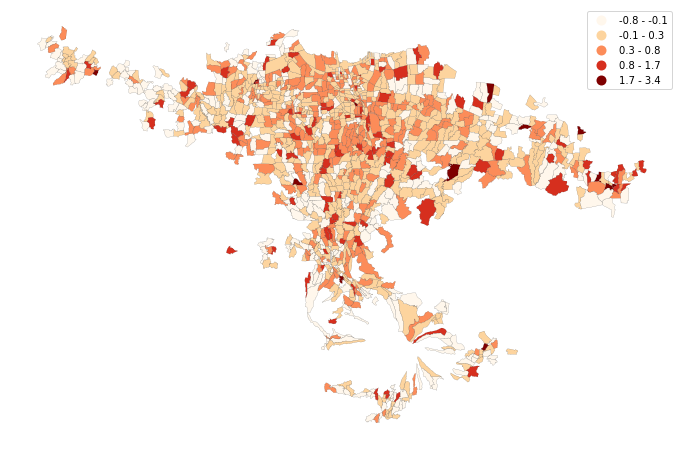

In [274]:
static_map(flow_changes,'outflow')

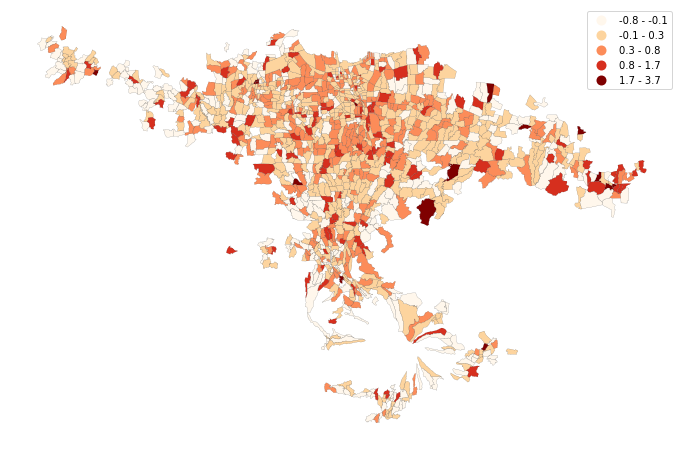

In [275]:
static_map(flow_changes,'inflow')